In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,'../../src')
from _generate_time_series import *
from _shear_frame import *
from utils_OB import *
from _clustering import *
import _tracking as tk
from utils_JK import *
import seaborn as sns
import hdbscan
sns.set_theme(context='paper',font_scale=1.0, style = 'ticks', color_codes='deep')
import scipy as sp

%load_ext autoreload
%autoreload 2

In [3]:
# stiffness and mass: 
kx=np.array([2,2])*4000
ky=kx
m=np.array([1,1])*500

n=150  #number of time series to run

#shapes for how the stiffnesses should behave trougout the time series:
base_shapey=np.hstack((np.linspace(
    1,1.3,n//2),np.linspace(1.5,1.3,n-n//2)))
base_shapex=np.sin(2*np.pi*base_shapey*20)*0.03+base_shapey

shapey=np.vstack((base_shapey,base_shapey**2))
shapex=np.vstack((base_shapex,base_shapex**0.5+0.4))

#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs=7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='new'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic=None
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0.2

### Noise fac for added measurments noice: 
noise_fac=1

#Number of times to run the
n_sim = 40

valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=35 
min_samples=12
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}

In [4]:
true_w,true_phi,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,
                                           white_noise_amp=white_noise_amp
                                           ,next_segment=next_segment
                                           ,next_DOF=next_DOF
                                           ,harmonic=harmonic
                                           ,harmonic_part=harmonic_part
                                           ,plot=False)

lambds,phis=create_input_COVssi(responses,t,orders)

ys=create_output_guassian(lambds)

til_jon=ys.T


In [5]:
phis_out,w_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=False)

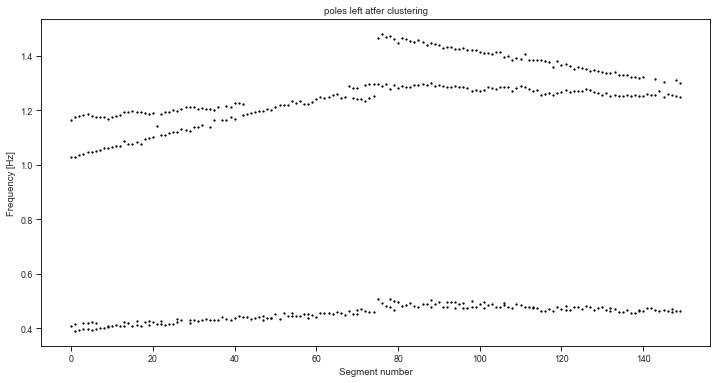

In [6]:
matplotlib.use('module://matplotlib_inline.backend_inline') #setting backend in case cells are not run in appropriate order


fig,ax =plt.subplots(figsize=(12,6))
for segment_number,lambd_i in enumerate(w_out):
    ax.scatter(np.ones_like(lambd_i)*segment_number,
               np.abs(lambd_i)**1/2/np.pi,color='black',s=2)
    ax.set_title('poles left atfer clustering')
    ax.set_xlabel('Segment number')
    ax.set_ylabel('Frequency [Hz]')
plt.show()

In [7]:
id_sort = np.argsort(true_w[0])
true_f_sorted = true_w[:,id_sort]/(2*np.pi)
true_phi_sorted = true_phi[id_sort,:,:]

# print(true_f_sorted[0])
# print(true_phi_sorted[:,:,0])

# ref_mode_frequenciesHz = true_f_sorted[0]
# ref_mode_modeshapes = true_phi_sorted[:,:,0]

In [8]:
freqs_out = radtoHz(w_out)

lim = 0.1

In [9]:
mode_traces_He = tk.perform_tracking_He2022(freqs_out, phis_out)

In [15]:
mode_traces_He_sorted = []

for i, init_true_f in enumerate(true_f_sorted[0]):
    init_true_phi = true_phi_sorted[i,:,0]
    print(init_true_f)
    print(init_true_phi)

    d_temp = np.array([])
    for j, trace in enumerate(mode_traces_He):
        dij = rel_diff(trace.frequencies[0], init_true_f) + 1 - MAC(trace.mode_shapes[0], init_true_phi)
        d_temp = np.append(d_temp, dij)
    
    id_min = np.argmin(d_temp)

    print(mode_traces_He[id_min].frequencies[0])
    print(np.real(mode_traces_He[id_min].mode_shapes[0]))

    print('----------')

    mode_traces_He_sorted.append(mode_traces_He[np.argmin(d_temp)])

print(mode_traces_He)
print(mode_traces_He_sorted)
    

0.39345265723338635
[0.         0.         0.61803399 1.        ]
0.40665887786018506
[0.58577585 0.82042479 0.0472226  0.08734821]
----------
0.40931885254297345
[0.7047192 1.        0.        0.       ]
0.40665887786018506
[0.58577585 0.82042479 0.0472226  0.08734821]
----------
1.0300724296009676
[ 0.          0.          1.         -0.61803399]
1.029807436063489
[-0.0192956   0.01261562  0.93261365 -0.55263659]
----------
1.1715545520019277
[ 1.        -0.7047192  0.         0.       ]
1.1635843116424267
[ 0.99967293 -0.65594291 -0.04364907  0.00109799]
----------
[<_tracking.ModeTrace object at 0x000001542D09B370>, <_tracking.ModeTrace object at 0x000001542D09B4C0>, <_tracking.ModeTrace object at 0x0000015412A53730>]
[<_tracking.ModeTrace object at 0x000001542D09B370>, <_tracking.ModeTrace object at 0x000001542D09B370>, <_tracking.ModeTrace object at 0x000001542D09B4C0>, <_tracking.ModeTrace object at 0x0000015412A53730>]


In [47]:
n = np.zeros_like(true_f_sorted[0])

for k, fk in enumerate(freqs_out):

    print('Time segment: {}'.format(k))
    print('*************')

    bool_list = np.full_like(n, False)

    for j, fkj in enumerate(fk):
        print('Clustered frequency: {:.3f} Hz'.format(fkj))

        phikj = phis_out[k][j,:]

        df_list = np.array([])
        dmac_list = np.array([])
        d_list = np.array([])

        for i, truefki in enumerate(true_f_sorted[k]):
            df = rel_diff(fkj, truefki)
            dmac = 1 - MAC(phikj, true_phi_sorted[i,:,k])
            
            df_list = np.append(df_list, df)
            dmac_list = np.append(dmac_list, dmac)
            d_list = np.append(d_list, df + dmac)

        id_min = np.argmin(d_list)

        if d_list[id_min] < lim: bool_list[id_min] = True
        
        print('Analytical frequency: {:.3f} Hz'.format(true_f_sorted[k][id_min]))
        print('The clustered mode is equal to true mode {}'.format(id_min))
        print('df: {:.4f}'.format(df_list[id_min]))
        print('mac: {:.4f}'.format(1 - dmac_list[id_min]))
        print('d: {}'.format(d_list[id_min]))

        print('-------------------')

    for i, isadded in enumerate(bool_list):
        if not isadded: n[i] += 1
    
    print(n)

    print('\n \n \n \n')


Time segment: 0
*************
Clustered frequency: 0.392 Hz
Analytical frequency: 0.393 Hz
The clustered mode is equal to true mode 0
df: 0.0031
mac: 0.9921
d: 0.011026624422357618
-------------------
Clustered frequency: 0.412 Hz
Analytical frequency: 0.409 Hz
The clustered mode is equal to true mode 1
df: 0.0071
mac: 0.9651
d: 0.04195769161652403
-------------------
Clustered frequency: 1.031 Hz
Analytical frequency: 1.030 Hz
The clustered mode is equal to true mode 2
df: 0.0010
mac: 0.9972
d: 0.003807687139968787
-------------------
Clustered frequency: 1.178 Hz
Analytical frequency: 1.172 Hz
The clustered mode is equal to true mode 3
df: 0.0055
mac: 0.9993
d: 0.006211909841577761
-------------------
[0. 0. 0. 0.]

 
 
 

Time segment: 1
*************
Clustered frequency: 0.391 Hz
Analytical frequency: 0.394 Hz
The clustered mode is equal to true mode 0
df: 0.0096
mac: 0.9488
d: 0.060768816129939555
-------------------
Clustered frequency: 0.416 Hz
Analytical frequency: 0.413 Hz
The

In [23]:
n = np.zeros_like(true_f[0])

for k, freqs_out_k in enumerate(freqs_out[:10]):

    bool_list = np.full_like(n, False)

    for j, freqs_out_kj in enumerate(freqs_out_k):
        phis_out_kj = phis_out[k][j,:]
        d_temp = np.array([])

        for i, true_mode_freq_i in enumerate(true_f[k]):
            true_phi_i = true_phi[i,:,k]
            d_temp = np.append(d_temp, rel_diff(true_mode_freq_i, freqs_out_kj) + 1 - MAC(true_phi_i, phis_out_kj))
        id_min = np.argmin(d_temp)
        
        if d_temp[id_min] <= lim and not bool_list[id_min]:
            bool_list[id_min] = True
    
    for i, isadded in enumerate(bool_list):
        if not isadded: n[i] += 1

print(n)

[1. 0. 1. 0.]


### Online automatic identification of the modal parameters of a long span arch bridge

In [15]:
mode_traces_magalhaes = tk.perform_tracking_magalhaes2008(freqs_out, phis_out)

In [16]:
n_skipped_clustering = n_skipped_time_seg_clustering2(freqs_out, phis_out, true_w/(2*np.pi), true_phi, df_lim=0.15, dmac_lim=0.2)
print(n_skipped_clustering)

[0. 1. 0. 2.]


In [17]:
for i, trace in enumerate(mode_traces_magalhaes):
    print(trace.n_skipped_time_seg)

0
0
1
3


<AxesSubplot:xlabel='Time segments', ylabel='Frequency [Hz]'>

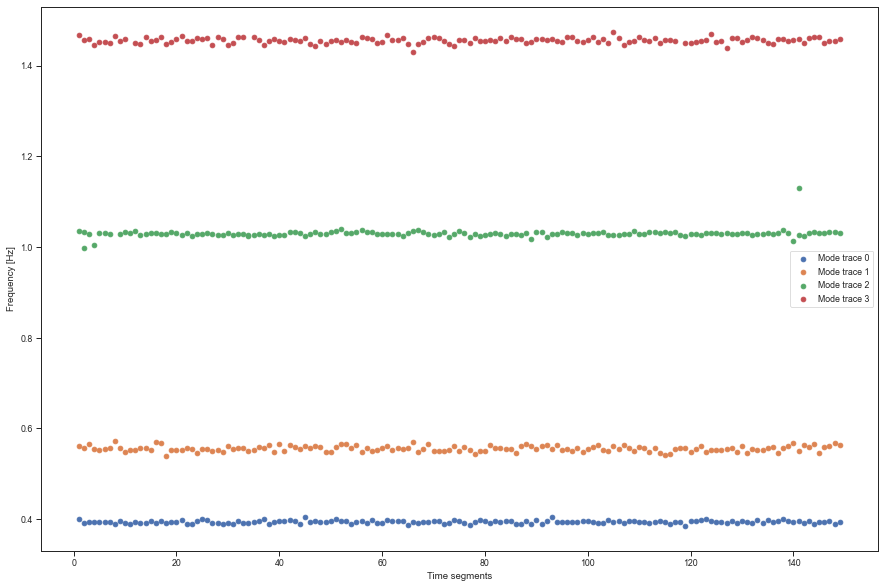

In [18]:
plot_physical_traces(mode_traces_magalhaes)

### Probabilistic implementation

In [5]:
data_true = np.load('../../Numerical test case/test_3/test_results/test_3_true.npz',allow_pickle=True)
true_f = data_true['arr_0']
true_phi = data_true['arr_1']

In [43]:
data = np.load('../../Numerical test case/test_3/test_results/test_3_run_'+str(2)+'.npz',allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

In [50]:
tcheck = 10
m = 15

update_ref = False
update_thresholds = True

df_max = 0.15
dmac_max = 0.2

mode_traces = []

freqsHz0 = freqs_out[0]
phi0 = phis_out[0]

#Initialize the traces with the poles of the first day
for i, fi in enumerate(freqsHz0):
    mode_traces.append(tk.ModeTrace(ref_frequency=fi, ref_mode_shape=phi0[i,:], init_time=0, df_threshold = df_max, dmac_threshold = dmac_max))
    mode_traces[-1].add_mode(f = fi, phi = phi0[i,:], time_stamp = 0)

#Iterate through the time segments
for k, fk in enumerate(freqs_out):

    if k == 0: continue

    for j, fkj in enumerate(fk):
        phikj = phis_out[k][j,:]

        #Initialize a boolean for the case of a pole not qualifying for a trace
        isadded = False

        #Use d = df + 1 - mac as a criteria to find the nearest mode to a trace
        d_temp = np.array([])

        #Store the dfs and macs to call after
        df_temp = np.array([])
        dmac_temp = np.array([])

        #Check the pole with each of the traces
        for i, mode_trace_i in enumerate(mode_traces):
            
            dfj = rel_diff(fkj, mode_trace_i.ref_frequency)
            dmacj = 1 - MAC(phikj, mode_trace_i.ref_mode_shape)
            
            df_temp = np.append(df_temp, dfj)
            dmac_temp = np.append(dmac_temp, dmacj)
            d_temp = np.append(d_temp, dfj + dmacj)

        id_min = np.argmin(d_temp)

        #Add mode to candidate modes of a trace if df and mac are acceptable
        if df_temp[id_min] <= mode_traces[id_min].df_threshold and dmac_temp[id_min] <= mode_traces[id_min].dmac_threshold:
            
            isadded = True
            mode_traces[id_min].add_candidate_mode(freq = fkj, phi = phikj, d = d_temp[id_min], df = df_temp[id_min], dmac = dmac_temp[id_min])
        
        #If a mode does not qualify for a trace, start a new one
        if not isadded:
            mode_traces.append(tk.ModeTrace(ref_frequency=fkj, ref_mode_shape=phikj,init_time=k, df_threshold = df_max, dmac_threshold = dmac_max))
            mode_traces[-1].add_mode(f = fkj, phi = phikj, time_stamp=k)
            mode_traces[-1].set_added_mode_in_curr_time_seg(True)

    new_traces = []

    #Go through the candidate modes and choose the closest mode to add to the trace. Start a new trace for the rest
    for i, trace in enumerate(mode_traces):
        
        #Skip trace if no modes qualify for it
        if not trace.candidate_modes_ds: continue

        id_min = np.argmin(trace.candidate_modes_ds)
        mode_traces[i].add_mode(f = trace.candidate_modes_freqs[id_min], phi = trace.candidate_modes_shapes[id_min], time_stamp = k)
        mode_traces[i].add_diff(dhf = trace.candidate_modes_df[id_min], dhmac = trace.candidate_modes_dmac[id_min])
        mode_traces[i].set_added_mode_in_curr_time_seg(True)

        freqs_leftover = [f for id, f in enumerate(trace.candidate_modes_freqs) if id != id_min]
        phis_leftover = [phi for id, phi in enumerate(trace.candidate_modes_shapes) if id != id_min]

        #Skip creation of new trace if there is only one candidate mode at a time segment
        if not freqs_leftover: continue

        #Create new traces for the rest of the candidate poles
        for j, freq_leftover in enumerate(freqs_leftover):
            new_traces.append(tk.ModeTrace(ref_frequency=freq_leftover, ref_mode_shape=phis_leftover[j], init_time=k, df_threshold = df_max, dmac_threshold = dmac_max))
            new_traces[-1].add_mode(f = freq_leftover, phi = phis_leftover[j], time_stamp = k)
            new_traces[-1].set_added_mode_in_curr_time_seg(True)
    
    #Add the new traces to the end of the mode traces list if there are any to be added
    if new_traces: 
        for new_trace in new_traces: mode_traces.append(new_trace)

    #Reset the candidate list and check if a mode was added to each trace in the current segment
    for i in range(len(mode_traces)): 
        mode_traces[i].reset_candidate_modes()
        mode_traces[i].check_added_mode_in_curr_time_seg()

    #Check for physicality each tcheck interval
    if k%tcheck == 0 and k > 0:
        for i in range(len(mode_traces)):
            if not mode_traces[i].check_mode_trace(tcheck, k):
                mode_traces[i].set_physicality(False)
            
    #Update the reference modes if specified
    if update_ref and k%m == 0 and k > 0:
        for i in range(len(mode_traces)):
            idupd = np.where(np.array(mode_traces[i].time_seg) > k - m)[0]
            
            update_timeseg = np.array(mode_traces[i].time_seg)[idupd]
            update_freqs = np.array(mode_traces[i].frequencies)[idupd]
            update_shapes = np.array(mode_traces[i].mode_shapes)[idupd]

            for j, t in enumerate(update_timeseg):
                mode_traces[i].add_mode_for_next_ref_mode(update_freqs[j], update_shapes[j], t)

            mode_traces[i].set_next_ref_mode(method = 'average')

    #Update thresholds after Cabboi if specified
    if k > 1 and update_thresholds:
        for i in range(len(mode_traces)):

            if len(mode_traces[i].dhf) > 1:

                #Use rules from article to calculate the new thresholds
                f_threshold_new_i = np.sqrt(np.std(mode_traces[i].dhf)*(1 + 1/(np.log(k))))
                dmac_threshold_new_i =  np.sqrt(np.std(mode_traces[i].dhmac)*(1 + 1/(np.log(k))))

                #Set the new thresholds to the traces
                mode_traces[i].set_threshold(df_threshold_new = f_threshold_new_i, dmac_threshold_new = dmac_threshold_new_i)
    

In [52]:
mode_traces = tk.perform_tracking_cabboi(freqs_out, phis_out, ref_mode_frequenciesHz=freqs_out[0], ref_mode_modeshapes=phis_out[0])

[0.1, 0.03321572526293085, 0.029373317105604937, 0.07353586222840419, 0.07012423108984531, 0.06874338077969236, 0.094889815122134, 0.09384991160989864, 0.09302947948659163, 0.09236137879237587, 0.09375178603110433, 0.10614215345873068, 0.11784996475755746, 0.11825453083658502, 0.11783985518977176, 0.1193537708385941, 0.13169045630107462, 0.13423723152364525, 0.1419611512654828, 0.14628865424682855, 0.14599500189927941, 0.15445717045389065, 0.1541893129534472, 0.15393945952643825, 0.15370564802664913, 0.15348620349863568, 0.16194377613862956, 0.1649880905582003, 0.1647895297677896, 0.16779098265860806, 0.16760886841221237, 0.17093196598062682, 0.17076345398707016, 0.17060262849141566, 0.17697030054614427, 0.1768175344507877, 0.18257027322265382, 0.18659879599037507, 0.18645609955496265, 0.18631884701511778, 0.18746097516781987, 0.18733272695675643, 0.1872089992403065, 0.1957066771277568, 0.1955858915185362, 0.19815154725779324, 0.1980369024003112, 0.20281231928488794, 0.2077311313700027

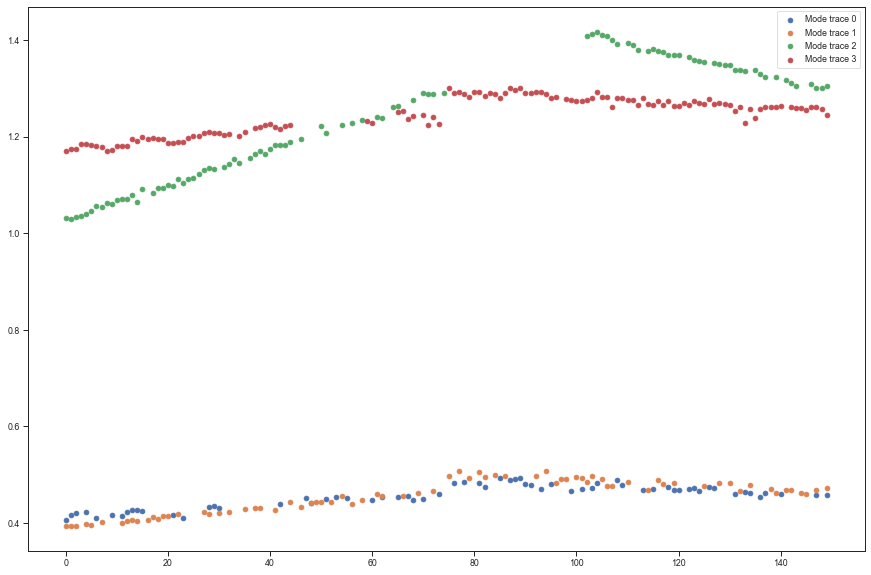

In [53]:
fig, ax = plt.subplots(figsize = (15,10))

for i, trace in enumerate(mode_traces):
    #if i == 4: break
    if trace.isphysical: ax.scatter(trace.time_seg, trace.frequencies, label = 'Mode trace {}'.format(i))

print(mode_traces[1].df_threshold_list)
ax.legend()

### Cabboi 2016 implementation

In [77]:
mode_traces = []
for k, ref_mode_frequencyHz in enumerate(ref_mode_frequenciesHz):
    mode_traces.append(tk.ModeTrace(ref_frequency=ref_mode_frequencyHz, ref_mode_shape=ref_mode_modeshapes[k,:]))

In [78]:
dfi_max = np.ones_like(mode_traces)*0.10
dmaci_max = np.ones_like(mode_traces)*0.10

for h, wh in enumerate(lambds_out):
    fh = wh/(2*np.pi)
    for j, fhj in enumerate(fh):
        phihj = phis_out[h][j,:]
        for i, mode_trace_i in enumerate(mode_traces):
            dhf_j = rel_diff(mode_trace_i.ref_frequency, fhj)
            dhmac_j = 1 - MAC(mode_trace_i.ref_mode_shape, phihj)
            if dhf_j <= dfi_max[i] and dhmac_j <= dmaci_max[i]:
                mode_traces[i].add_mode(f = fhj, phi = phihj, time_stamp = h)
                mode_traces[i].add_diff(dhf = dhf_j, dhmac = dhmac_j)

    #Update the thresholds after each time segment  
    if h > 1:
        for i in range(dfi_max.shape[0]):
            if len(mode_traces[i].dhf) > 1:
                dfi_max[i] = np.sqrt(np.std(mode_traces[i].dhf)*(1 + 1/(np.log(h))))
                dmaci_max[i] = np.sqrt(np.std(mode_traces[i].dhmac)*(1 + 1/(np.log(h))))

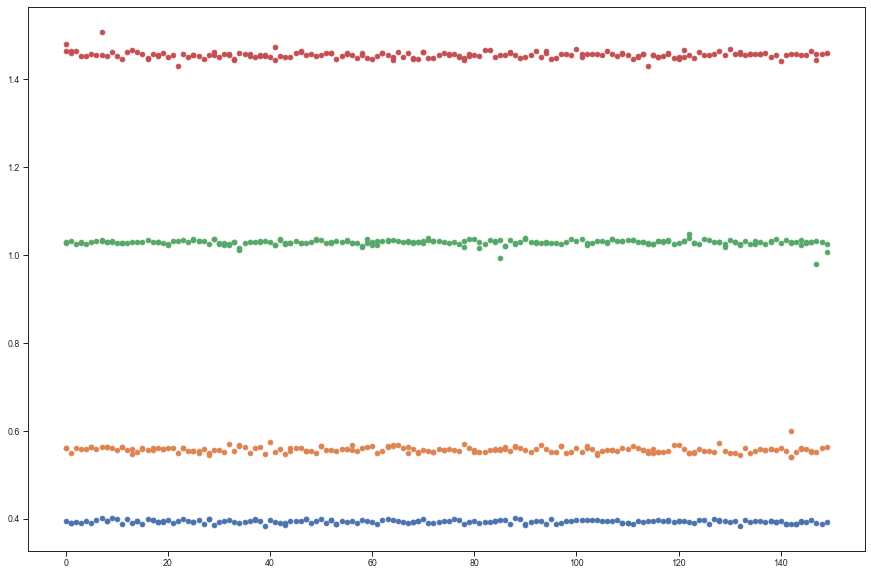

In [79]:
fig, axis = plt.subplots(figsize = (15,10))
for i in range(len(mode_traces)):
    plt.scatter(mode_traces[i].time_seg, mode_traces[i].frequencies)

In [27]:
class ModeTrace():
    def __init__(self, ref_frequency, ref_mode_shape, init_time,  df_threshold = 0.1, dmac_threshold = 0.1):
        """
        A class for a mode trace over time. Currently uses mean of next modes for new reference mode or linear extrapolation.

        Arguments
        --------
        ref_frequency: float
            initial reference frequency
        
        ref_mode_shape: 1D array
            initial reference mode shape

        df_threshold: float
            initial maximum difference in frequency from the reference mode a candiate mode can have

        dmac_threshold: float
            initial maximum 1 - MAC from the reference mode a candidate mode can have
        """

        self.ref_frequency = ref_frequency
        self.ref_mode_shape = ref_mode_shape

        self.frequencies = []
        self.mode_shapes = []
        self.time_seg = []
        
        self.ref_mode_frequency_temp = []
        self.ref_mode_shape_temp = []
        self.ref_time_stamp_temp = []

        self.n_skipped_time_seg = init_time
        self.added_mode_in_curr_time_seg = False

        self.dhf = []
        self.dhmac = []

        self.isphysical = True

        self.candidate_modes_freqs = []
        self.candidate_modes_shapes = []
        self.candidate_modes_ds = []
        self.candidate_modes_df = []
        self.candidate_modes_dmac = []

        self.df_threshold = df_threshold
        self.dmac_threshold = dmac_threshold
        self.df_threshold_list = [df_threshold]
        self.dmac_threshold_list = [dmac_threshold]

        self.djtrack_list = []


    def add_mode(self, f, phi, time_stamp):
        """
        Add a mode to the trace
        """
        self.frequencies.append(f)
        self.mode_shapes.append(phi)
        self.time_seg.append(time_stamp)

    def set_ref_mode(self, new_f_reference, new_mode_shape_reference):
        """
        Manually set a reference mode. Not used in current scheme
        """
        self.ref_frequency = new_f_reference
        self.ref_mode_shape = new_mode_shape_reference

    def add_mode_for_next_ref_mode(self, f_ref, mode_shape_ref, time_stamp_ref):
        """
        Add a mode to be used when calculating the next reference mode in the funtion "set_next_ref_mode"
        """
        self.ref_mode_frequency_temp.append(f_ref)
        self.ref_mode_shape_temp.append(mode_shape_ref)
        self.ref_time_stamp_temp.append(time_stamp_ref)

    def set_next_ref_mode(self, method = 'average'):
        """
        Calculate the next reference mode based on the added modes. Reset the temp list for modes to be used for calculation.
        """

        if len(self.ref_mode_frequency_temp) == 0 or len(self.ref_mode_frequency_temp) == 1:
            pass
        
        else:

            #phi_temp_norm,_ = koma.modal.normalize_phi(np.array(self.ref_mode_shape_temp).T)
            phi_temp_norm = koma.modal.align_modes(np.array(self.ref_mode_shape_temp).T)
            phi_temp_norm = phi_temp_norm.T    
            
            if method == 'average':

                self.ref_frequency = np.mean(self.ref_mode_frequency_temp)
                self.ref_mode_shape = np.mean(phi_temp_norm,axis = 0)

            elif method == 'linear_extrapolation':

                X = np.vstack([np.ones(len(self.ref_time_stamp_temp)), self.ref_time_stamp_temp]).T
                
                try:
                    bf = np.linalg.solve(X.T @ X, X.T @ self.ref_mode_frequency_temp)

                    self.ref_frequency = bf[0] + bf[1] *(X[-1, -1] + 1)

                    phi_next = np.zeros_like(self.ref_mode_shape)

                    for i in range(phi_next.shape[0]):
                        yi = phi_temp_norm[:,i]
                        bi = np.linalg.solve(X.T @ X, X.T @ yi)
                        phi_next[i] = bi[0] + bi[1] *(X[-1, -1] + 1)

                    self.ref_mode_shape = phi_next

                #Rare case of a division containing two modes at the same time segment. Use average
                except:
                    self.ref_frequency = np.mean(self.ref_mode_frequency_temp)
                    self.ref_mode_shape = np.mean(phi_temp_norm,axis = 0)


            self.ref_mode_frequency_temp = []
            self.ref_mode_shape_temp = []
            self.ref_time_stamp_temp = []

    def set_error(self, true_mode_frequency):
        """
        Calculate the error at each time segment from the true mode frequency at the same time segment. 
        True mode frequencies need to be sorted by frequencies

        Arguments
        ----------
        true_mode_frequency: 1D array
            true mode frequencies in the online phase
        """
        error = np.array([])

        t_true = np.arange(0,true_mode_frequency.shape[0])

        for j, f_truej in enumerate(true_mode_frequency):
            
            id_f_track = np.where(self.time_seg == t_true[j])[0]
            f_trackj = np.array(self.frequencies)[id_f_track]

            error = np.append(error, np.abs(f_truej - f_trackj))
        
        self.error = error
    
    def set_added_mode_in_curr_time_seg(self, added_mode_in_curr_time_seg):
        """
        If a mode was added in the current time segment, set to true. Else this is false
        """
        self.added_mode_in_curr_time_seg = added_mode_in_curr_time_seg

    def check_added_mode_in_curr_time_seg(self):
        """
        Run this after the time segment is completed. If self.added_mode_in_curr_time_seg is False, count a time segment where the
        trace failed to find a mode. Reset self.added_mode_in_curr_time_seg
        """
        if not self.added_mode_in_curr_time_seg:
            self.n_skipped_time_seg += 1
            self.added_mode_in_curr_time_seg = False
        else:
            self.added_mode_in_curr_time_seg = False

    def add_diff(self, dhf, dhmac, djtrack = 0):
        '''
        Add difference measure from the reference mode at the current time stamp
        '''
        self.dhf.append(dhf)
        self.dhmac.append(dhmac)
        self.djtrack_list.append(djtrack)

    def check_mode_trace(self, tcheck, k):
        '''
        Check if a mode trace most likely containts physical or mathematical modes, 
        based on the distance in time between the two last added modes. Return False if the distance is too large.
        '''
        #Don't call this function at the first time segment

        #Wait for the next check if only one mode has been added in the current 'checking interval',
        #could discover a mode at the end.
        if len(self.time_seg) == 1 and np.abs(self.time_seg[0] - k) < tcheck:
            return True
        
        elif len(self.time_seg) == 1:
            return False
        
        else:
            tdist = self.time_seg[-1] - self.time_seg[-2]
            if tdist >= tcheck:
                return False
            elif self.time_seg[-1] + tcheck < k:
                return False
            else:
                return True
        
    def set_physicality(self, bol):
        '''
        Set the physicality of the trace
        '''
        self.isphysical = bol

    def remove_mode(self, index):
        '''
        Remove modes at the index
        '''
        self.frequencies.pop(index)
        self.mode_shapes.pop(index)
        self.time_seg.pop(index)

    def add_candidate_mode(self, freq, phi, d, df, dmac):
        '''
        Add a candidate mode
        '''
        self.candidate_modes_freqs.append(freq)
        self.candidate_modes_shapes.append(phi)
        self.candidate_modes_ds.append(d)
        self.candidate_modes_df.append(df)
        self.candidate_modes_dmac.append(dmac)

    def reset_candidate_modes(self):
        '''
        Reset the candidate modes list
        '''
        self.candidate_modes_freqs = []
        self.candidate_modes_shapes = []
        self.candidate_modes_ds = []
        self.candidate_modes_df = []
        self.candidate_modes_dmac = []

    def set_threshold(self, df_threshold_new, dmac_threshold_new):
        '''
        Set new thresholds
        '''
        self.df_threshold = df_threshold_new
        self.dmac_threshold = dmac_threshold_new
        self.df_threshold_list.append(df_threshold_new)
        self.dmac_threshold_list.append(dmac_threshold_new)

    def count_missed_times_segments(self, freqs_out, phis_out, true_mode_f, true_mode_phi, lim):
        '''
        Postprocessing tool to count how many times the trace missed a mode in a segment, or chose a mode which does not
        belong in the trace to the trace.

        Two cases:
        1) Freqs out contains the analytical mode within the limit, but the trace did not find it
        2) Freqs out does not contain the analytical mode within the limit, but trace contains a mode at the current time segment

        Prerequisite: AOMA step gave output modes at each time segment

        Arguments
        ------------
        freqs_out: list of 1D arrays
            AOMA frequencies at each time segment
        phis_out: list of 2D arrays
            AOMA mode shapes at each time segment
        true_mode_f: 1D array
            True mode frequency at each time segment
        true_mode_phi: 2D array
            True mode shape at each time segment, stacked column-wise.
            true_mode_phi[:,k] = true mode shape at k-th day
        '''
        for k, fk in enumerate(freqs_out):

            d_list = np.array([])
            
            for j, fkj in enumerate(fk):
                phikj = phis_out[k][j,:]

                dfkj = rel_diff(fkj, true_mode_f[k])
                dmackj = 1 - MAC(phikj, true_mode_phi[:,k])

                d_list = np.append(d_list, dfkj + dmackj)

            id_min = np.argmin(d_list)

            id_trace = np.where(np.array(self.time_seg) == k)[0]

            print('Time segment {}'.format(k))
            print('AOMA output modes: ')
            print(fk)
            print('True mode frequency: {:.2f}'.format(true_mode_f[k]))
            trace_freq = np.array(self.frequencies)[id_trace]
            print('Trace frequency:')
            print(trace_freq)
            
            if d_list[id_min] <= lim:
                print('AOMA found the mode')

                #If the AOMA mode is close enough to the analytical mode, but the trace does not contain any modes: +1
                if len(id_trace) == 0: 
                    self.n_skipped_time_seg += 1

                #If the AOMA mode is close enough to the analytical mode, but the trace does not contain the AOMA mode: +1
                elif not np.array(self.frequencies)[id_trace][0] == fk[id_min]: 
                    self.n_skipped_time_seg += 1

                else:
                    print('Hit')
                    
            else:
                #The AOMA-step failed to discover the mode. If the trace contains a mode at the current time segment: +1
                if len(id_trace) != 0: 
                    print('Trace contains frequency {:.2f}, but it is not close enough to the analytical frequency'.format(trace_freq[0]))
                    print('Analytical mode shape:')
                    print(true_mode_phi[:,k])
                    print('Trace mode shape:')
                    print(np.real(np.array(self.mode_shapes)[id_trace]))
                    self.n_skipped_time_seg += 1

            print('Missed thus far: {}'.format(self.n_skipped_time_seg))
            print('-----------------------')




In [28]:
def get_initial_modes(freqs_inital, phis_initial):
    """
    Calculate the initial reference modes by clustering the initial phase based only on frequency

    Arguments
    ----------
    freqs_initial: list of 1D arrays
        frequencies from the time segments in the initial phase

    phis_initial: list of 2D arrays
        mode shapes from the time segments in the initial phase. Row-wise modes in the 2D arrays

    Returns
    ---------
    mode_traces_initial: list
        list of mode objects from the class ModeTrace
    """
    
    #Initialize flattened lists of frequencies and shapes
    freqs_inital_flat = []
    phis_inital_flat = []

    #Add all the frequencies and shapes to the flattened lists
    for k, fk in enumerate(freqs_inital):
        phik = phis_initial[k]
        for j, fkj in enumerate(fk):
            phikj = phik[j,:]
            freqs_inital_flat.append(fkj)
            phis_inital_flat.append(phikj)

    #Convert to numpy arrays (Easiest to append a 1D array to a python list and the convert to numpy)
    freqs_inital_flat = np.array(freqs_inital_flat)
    phis_inital_flat = np.array(phis_inital_flat)

    #Prepare distance metric for clustering call
    n_modes = len(freqs_inital_flat)
    d_mat = np.zeros([n_modes, n_modes])

    #Calculate the distance between the input modes in a matrix format
    for k, fk in enumerate(freqs_inital_flat):
        phik = phis_inital_flat[k,:]
        for j, fj in enumerate(freqs_inital_flat[k:]):
            j+=k
            phij = phis_inital_flat[j,:]
            df_jk = rel_diff(fk, fj)
            mac_jk = MAC(phik, phij)
            d_jk = df_jk + 1 - mac_jk
            if d_jk < 1e-10:
                d_mat[k, j] = 1
            else:
                d_mat[k, j] = d_jk
                d_mat[j, k] = d_jk

    #int(np.ceil(len(freqs_inital)*0.9))

    #Clustering call (Use 80% of n as minimum cluster size to avoid more clusters in the same mode and to account for some modes lost in the initial phase)
    clusterer = hdbscan.HDBSCAN(metric='precomputed', min_samples=5 ,min_cluster_size=10, alpha=1.0, gen_min_span_tree=False)
    clusterer.fit(d_mat)
    #_, main_ax = plt.subplots(figsize = (15,10))
    #clusterer.minimum_spanning_tree_.plot(axis = main_ax, edge_cmap='cividis',
    #                                  edge_alpha=0.6,
    #                                  node_size=80,
    #                                  edge_linewidth=2)

    #Initialize list of initial mode traces
    mode_trace_initial = np.array([])

    #Initialize list for sorting based on frequency
    freq_temp = np.array([])

    #Calculate the mean mode shape and frequency and create mode trace instances for the detected modes
    for label in range(clusterer.labels_.max()+1):
            
        f0_temp = freqs_inital_flat[np.where(clusterer.labels_ == label)[0]]
        phi0_temp = phis_inital_flat[np.where(clusterer.labels_ == label)[0]]

        #phi0_temp, _ = koma.modal.normalize_phi(phi0_temp.T)
        phi0_temp = koma.modal.align_modes(phi0_temp.T)
        phi0_temp = phi0_temp.T 

        mode_trace_i = ModeTrace(ref_frequency=np.mean(f0_temp), ref_mode_shape=np.mean(phi0_temp,axis = 0),init_time=0)
        mode_trace_initial = np.append(mode_trace_initial, mode_trace_i)

        freq_temp = np.append(freq_temp, np.mean(f0_temp))

    #Sort the traces based on frequency
    idsort = np.argsort(freq_temp)
    mode_trace_initial = mode_trace_initial[idsort]

    #print('Initial Phase Done')

    return mode_trace_initial


In [29]:
def divide_modes2(freqsHz, phis, freq_lim):
    '''
    Divide input modes based on a frequency limit

    Arguments
    ---------
    freqsHz: 1D array

    phis: 2D array

    freq_lim: float
        frequency in Hz for which to divide the modes
    '''

    id_above = np.where(freqsHz > freq_lim)[0]
    id_below = np.where(freqsHz <= freq_lim)[0]

    freqsHz_above = freqsHz[id_above]
    freqsHz_below = freqsHz[id_below]
    phis_above = phis[id_above]
    phis_below = phis[id_below]

    return freqsHz_above, freqsHz_below, phis_above, phis_below


In [30]:
def distance_matrix(freqs, phis):
    '''
    Create the HDBSCAN clustering matrix
    '''
    #Prepare distance metric for clustering call
    n_modes = len(freqs)
    d_mat = np.zeros([n_modes, n_modes])

    #Calculate the distance between the input modes in a matrix format
    for k, fk in enumerate(freqs):
        phik = phis[k,:]
        for j, fj in enumerate(freqs[k:]):
            j+=k
            phij = phis[j,:]
            df_jk = rel_diff(fk, fj)
            mac_jk = MAC(phik, phij)
            d_jk = df_jk + 1 - mac_jk
            if d_jk < 1e-10:
                d_mat[k, j] = 1
            else:
                d_mat[k, j] = d_jk
                d_mat[j, k] = d_jk

    return d_mat

In [31]:
def divide_segment(inlist, m):
    """
    Return a list of the divided segments of lenght m of the inlist
    """
    if len(inlist)%m == 0:
        divlist = np.arange(0, len(inlist)+1, m)
    else:
        divlist = np.arange(0, len(inlist), m)
        divlist = np.append(divlist, divlist[-1]+len(inlist)%m)
    return divlist

In [32]:
def get_initial_modes2(freqs_inital, phis_initial):
    """
    Calculate the initial reference modes by clustering the initial phase based only on frequency

    Arguments
    ----------
    freqs_initial: list of 1D arrays
        frequencies from the time segments in the initial phase

    phis_initial: list of 2D arrays
        mode shapes from the time segments in the initial phase. Row-wise modes in the 2D arrays

    Returns
    ---------
    mode_traces_initial: list
        list of mode objects from the class ModeTrace
    """
    
    #Initialize flattened lists of frequencies and shapes
    freqs_inital_flat = []
    phis_inital_flat = []

    #Add all the frequencies and shapes to the flattened lists
    for k, fk in enumerate(freqs_inital):
        phik = phis_initial[k]
        for j, fkj in enumerate(fk):
            phikj = phik[j,:]
            freqs_inital_flat.append(fkj)
            phis_inital_flat.append(phikj)

    #Convert to numpy arrays (Easiest to append a 1D array to a python list and the convert to numpy)
    freqs_inital_flat = np.array(freqs_inital_flat)
    phis_inital_flat = np.array(phis_inital_flat)

    #Get distance matrix for first clustering step
    d_mat1 = distance_matrix_koma(freqs_inital_flat, phis_inital_flat)

    #Clustering call (Use 80% of n as minimum cluster size to avoid more clusters in the same mode and to account for some modes lost in the initial phase)
    clusterer1 = hdbscan.HDBSCAN(metric='precomputed', min_samples=5 ,min_cluster_size=10, alpha=1.0, gen_min_span_tree=False)
    clusterer1.fit(d_mat1)
    #_, main_ax = plt.subplots(figsize = (15,10))
    #clusterer.minimum_spanning_tree_.plot(axis = main_ax, edge_cmap='cividis',
    #                                  edge_alpha=0.6,
    #                                  node_size=80,
    #                                  edge_linewidth=2)

    #Inizialize a list for the frequencies from the first clustering step
    f1 = np.array([])

    #Find f_split
    for label in range(clusterer1.labels_.max()+1):
        f1_temp = freqs_inital_flat[np.where(clusterer1.labels_ == label)[0]]
        f1 = np.append(f1, np.mean(f1_temp))

    f1_sorted = np.sort(f1)
    max_difference_index = np.argmax(np.diff(f1_sorted))
    f_split = (f1_sorted[max_difference_index + 1] + f1_sorted[max_difference_index])/2 

    #Extract divided modes
    id_div_above = np.where(freqs_inital_flat > f_split)[0]
    id_all = np.arange(freqs_inital_flat.shape[0])
    id_div_below = np.setdiff1d(id_all, id_div_above)
    
    freqs_inital_flat_above = freqs_inital_flat[id_div_above]
    freqs_inital_flat_below = freqs_inital_flat[id_div_below]

    phis_inital_flat_above = phis_inital_flat[id_div_above]
    phis_inital_flat_below = phis_inital_flat[id_div_below]

    #Create d_mats for step 2
    d_mat2_above = d_mat1[id_div_above][:,id_div_above]
    d_mat2_below = d_mat1[id_div_below][:,id_div_below]

    #Cluster call
    clusterer2_above = hdbscan.HDBSCAN(metric='precomputed', min_samples=5 ,min_cluster_size=10, alpha=1.0, gen_min_span_tree=False)
    clusterer2_above.fit(d_mat2_above)

    clusterer2_below = hdbscan.HDBSCAN(metric='precomputed', min_samples=5 ,min_cluster_size=10, alpha=1.0, gen_min_span_tree=False)
    clusterer2_below.fit(d_mat2_below)

    #Initialize list of initial mode traces
    mode_trace_initial = np.array([])

    #Initialize list for sorting based on frequency
    freq_temp = np.array([])

    #Calculate the mean mode shape and frequency and create mode trace instances for the detected modes for frequencies above split
    for label in range(clusterer2_above.labels_.max()+1):
            
        f0_temp1 = freqs_inital_flat_above[np.where(clusterer2_above.labels_ == label)[0]]
        phi0_temp1 = phis_inital_flat_above[np.where(clusterer2_above.labels_ == label)[0]]

        #phi0_temp, _ = koma.modal.normalize_phi(phi0_temp.T)
        phi0_temp1 = koma.modal.align_modes(phi0_temp1.T)
        phi0_temp1 = phi0_temp1.T 

        mode_trace_i = ModeTrace(ref_frequency=np.mean(f0_temp1), ref_mode_shape=np.mean(phi0_temp1,axis = 0),init_time=0)
        mode_trace_initial = np.append(mode_trace_initial, mode_trace_i)

        freq_temp = np.append(freq_temp, np.mean(f0_temp1))

    #Calculate the mean mode shape and frequency and create mode trace instances for the detected modes for frequencies above split
    for label in range(clusterer2_below.labels_.max()+1):
            
        f0_temp2 = freqs_inital_flat_below[np.where(clusterer2_below.labels_ == label)[0]]
        phi0_temp2 = phis_inital_flat_below[np.where(clusterer2_below.labels_ == label)[0]]

        #phi0_temp, _ = koma.modal.normalize_phi(phi0_temp.T)
        phi0_temp2 = koma.modal.align_modes(phi0_temp2.T)
        phi0_temp2 = phi0_temp2.T 

        mode_trace_i = ModeTrace(ref_frequency=np.mean(f0_temp2), ref_mode_shape=np.mean(phi0_temp2,axis = 0),init_time=0)
        mode_trace_initial = np.append(mode_trace_initial, mode_trace_i)

        freq_temp = np.append(freq_temp, np.mean(f0_temp2)) 

    #Sort the traces based on frequency
    idsort = np.argsort(freq_temp)
    mode_trace_initial = mode_trace_initial[idsort]

    #print('Initial Phase Done')

    return mode_trace_initial


In [33]:
def perform_tracking2(freqs, phis, n = 20, m = 5, d_track_threshold = 0.1, method = 'average'):
    """
    Perform mode tracking on modes over time.

    Arguments
    ----------
    freqs: list of 1D arrays
        frequencies over time. Each array comes from seperate time segments
    
    phis: list of 2D arrays
        mode shapes over time

    n: int
        Amount of time segments from the inital phase to be used for calculating the initial reference modes

    m: int
        Amount of time segments ahead of each reference point to be used for calculation of the next reference modes

    d_track_treshold: float
        limit for highest value of dj_track to qualify a mode for a trace

    method: string
        either 'average' or 'linear_extrapolation'
    
    Returns
    ---------
    mode_traces: list
        List of mode trace object defined according to the mode trace class in this file

    """
    freqs_inital = freqs[:n]
    phis_initial = phis[:n]

    freqs_online = freqs[n:]
    phis_online = phis[n:]

    mode_traces = get_initial_modes2(freqs_inital, phis_initial)
    
    online_div = divide_segment(freqs_online, m)

    for seg_i in range(online_div.shape[0]-1):

        for k, fk in enumerate(freqs_online[online_div[seg_i]:online_div[seg_i+1]]):

            for j, fkj in enumerate(fk):
                phikj = phis_online[online_div[seg_i]:online_div[seg_i+1]][k][j,:]

                dj_track_temp = np.array([])
                for mode_trace in mode_traces:
                    df = rel_diff(fkj, mode_trace.ref_frequency)
                    mac_kj = MAC(phikj, mode_trace.ref_mode_shape)
                    dj_track = df + 1 - mac_kj
                    dj_track_temp = np.append(dj_track_temp, dj_track)

                #Skip this if there are no AOMA modes in the current time segment
                if len(dj_track_temp) != 0:

                    id_mode = np.argmin(dj_track_temp)

                    #Add all modes that qualify for a trace as a candidate
                    if dj_track_temp[id_mode] <= d_track_threshold:
                        mode_traces[id_mode].add_candidate_mode(fkj, phikj, d = dj_track_temp[id_mode], df = 0, dmac = 0)

            for i, trace in enumerate(mode_traces):
                
                #Skip trace if no modes qualify for it
                if not trace.candidate_modes_ds: continue

                #Only add the closest candidate mode, discard the rest
                id_min = np.argmin(trace.candidate_modes_ds)
                mode_traces[i].add_mode(f = trace.candidate_modes_freqs[id_min], phi = trace.candidate_modes_shapes[id_min], time_stamp = online_div[seg_i] + k)
                mode_traces[i].add_mode_for_next_ref_mode(trace.candidate_modes_freqs[id_min], trace.candidate_modes_shapes[id_min], time_stamp_ref = k)
                mode_traces[i].reset_candidate_modes()

        for i in range(len(mode_traces)):
            mode_traces[i].set_next_ref_mode(method)

    return mode_traces

In [34]:
data = np.load('./../../Numerical test case/test_3/test_results/test_3_run_0.npz', allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

In [35]:
freqs_test = freqs_out[:1]
phis_test = phis_out[:1]

print(freqs_test)
print(phis_test)

#Initialize flattened lists of frequencies and shapes
freqs_test_flat = []
phis_test_flat = []

#Add all the frequencies and shapes to the flattened lists
for k, fk in enumerate(freqs_test):
    phik = phis_test[k]
    for j, fkj in enumerate(fk):
        phikj = phik[j,:]
        freqs_test_flat.append(fkj)
        phis_test_flat.append(phikj)

#Convert to numpy arrays (Easiest to append a 1D array to a python list and the convert to numpy)
freqs_test_flat = np.array(freqs_test_flat)
phis_test_flat = np.array(phis_test_flat)

#Prepare distance metric for clustering call
n_modes = len(freqs_test_flat)
d_mat = np.zeros([n_modes, n_modes])

#Calculate the distance between the input modes in a matrix format
for k, fk in enumerate(freqs_test_flat):
    phik = phis_test_flat[k,:]
    for j, fj in enumerate(freqs_test_flat[k:]):
        j+=k
        phij = phis_test_flat[j,:]
        df_jk = rel_diff(fk, fj)
        mac_jk = MAC(phik, phij)
        d_jk = df_jk + 1 - mac_jk
        print('(k, j) = ('+str(k)+','+str(j)+')')
        print('f0 = {:.2f}'.format(fk))
        print('f1 = {:.2f}'.format(fj))
        print('mac_jk = {:.2f}'.format(mac_jk))
        print('djk = {}'.format(d_jk))
        print('------------------')
        if d_jk < 1e-10:
            d_mat[k, j] = 1
        else:
            d_mat[k, j] = d_jk
            d_mat[j, k] = d_jk


for row in d_mat:
    print(row)

[array([0.39313914, 1.02767258, 1.17117773])]
[array([[-0.06851738-0.02142691j, -0.08252036-0.04251676j,
          0.62029103+0.00251858j,  0.99991846-0.01277021j],
        [-0.00250775+0.00591723j, -0.00566266-0.00090996j,
          0.95030655+0.20660025j, -0.57617816-0.17097713j],
        [ 0.99995562+0.00942111j, -0.70882009+0.01292247j,
          0.007944  -0.02061428j, -0.01143313+0.0196875j ]])]
(k, j) = (0,0)
f0 = 0.39
f1 = 0.39
mac_jk = 1.00
djk = 0.0
------------------
(k, j) = (0,1)
f0 = 0.39
f1 = 1.03
mac_jk = 0.00
djk = 1.6157489683697797
------------------
(k, j) = (0,2)
f0 = 0.39
f1 = 1.17
mac_jk = 0.00
djk = 1.6641680654808497
------------------
(k, j) = (1,1)
f0 = 1.03
f1 = 1.03
mac_jk = 1.00
djk = 0.0
------------------
(k, j) = (1,2)
f0 = 1.03
f1 = 1.17
mac_jk = 0.00
djk = 1.12163434130859
------------------
(k, j) = (2,2)
f0 = 1.17
f1 = 1.17
mac_jk = 1.00
djk = 0.0
------------------
[1.         1.61574897 1.66416807]
[1.61574897 1.         1.12163434]
[1.66416807 1.

In [36]:
def perform_tracking(freqs, phis, n = 20, m = 5, d_track_threshold = 0.1, method = 'average'):
    """
    Perform mode tracking on modes over time.

    Arguments
    ----------
    freqs: list of 1D arrays
        frequencies over time. Each array comes from seperate time segments
    
    phis: list of 2D arrays
        mode shapes over time

    n: int
        Amount of time segments from the inital phase to be used for calculating the initial reference modes

    m: int
        Amount of time segments ahead of each reference point to be used for calculation of the next reference modes

    d_track_treshold: float
        limit for highest value of dj_track to qualify a mode for a trace

    method: string
        either 'average' or 'linear_extrapolation'
    
    Returns
    ---------
    mode_traces: list
        List of mode trace object defined according to the mode trace class in this file

    """
    freqs_inital = freqs[:n]
    phis_initial = phis[:n]

    freqs_online = freqs[n:]
    phis_online = phis[n:]

    mode_traces = get_initial_modes(freqs_inital, phis_initial)
    
    online_div = divide_segment(freqs_online, m)

    for seg_i in range(online_div.shape[0]-1):

        for k, fk in enumerate(freqs_online[online_div[seg_i]:online_div[seg_i+1]]):

            for j, fkj in enumerate(fk):
                phikj = phis_online[online_div[seg_i]:online_div[seg_i+1]][k][j,:]

                dj_track_temp = np.array([])
                for mode_trace in mode_traces:
                    df = rel_diff(fkj, mode_trace.ref_frequency)
                    mac_kj = MAC(phikj, mode_trace.ref_mode_shape)
                    dj_track = df + 1 - mac_kj
                    dj_track_temp = np.append(dj_track_temp, dj_track)

                #Skip this if there are no AOMA modes in the current time segment
                if len(dj_track_temp) != 0:

                    id_mode = np.argmin(dj_track_temp)

                    #Add all modes that qualify for a trace as a candidate
                    if dj_track_temp[id_mode] <= d_track_threshold:
                        mode_traces[id_mode].add_candidate_mode(fkj, phikj, d = dj_track_temp[id_mode], df = 0, dmac = 0)

            for i, trace in enumerate(mode_traces):
                
                #Skip trace if no modes qualify for it
                if not trace.candidate_modes_ds: continue

                #Only add the closest candidate mode, discard the rest
                id_min = np.argmin(trace.candidate_modes_ds)
                mode_traces[i].add_mode(f = trace.candidate_modes_freqs[id_min], phi = trace.candidate_modes_shapes[id_min], time_stamp = online_div[seg_i] + k)
                mode_traces[i].add_mode_for_next_ref_mode(trace.candidate_modes_freqs[id_min], trace.candidate_modes_shapes[id_min], time_stamp_ref = k)
                mode_traces[i].reset_candidate_modes()

        for i in range(len(mode_traces)):
            mode_traces[i].set_next_ref_mode(method)

    return mode_traces


In [37]:
data_true = np.load('../../Numerical test case/test_3/test_results/test_3_true.npz',allow_pickle=True)
true_f = data_true['arr_0']
true_phi = data_true['arr_1']

data = np.load('../../Numerical test case/test_3/test_results/test_3_run_'+str(8)+'.npz',allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

In [38]:
mode_traces_mtc1 = perform_tracking2(freqs_out, phis_out, n = 40, m = 11,d_track_threshold=0.3 ,method = 'average')

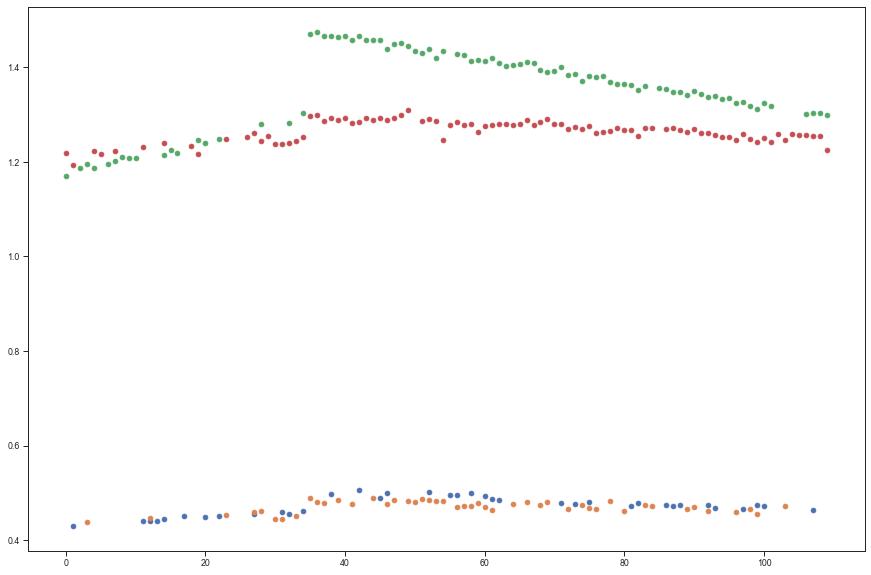

In [39]:
fig, axis = plt.subplots(figsize = (15,10))
for i in range(len(mode_traces_mtc1)):
    plt.scatter(mode_traces_mtc1[i].time_seg, mode_traces_mtc1[i].frequencies)

In [155]:
mode_traces_mtc1[0].count_missed_times_segments(freqs_out[25:], phis_out[25:], true_mode_f=true_f[25:,0], true_mode_phi=true_phi[0,:,25:], lim=0.3)
print(mode_traces_mtc1[0].n_skipped_time_seg)

Time segment 0
AOMA output modes: 
[0.4213775  1.11336653 1.20095335]
True mode frequency: 0.42
Trace frequency:
[]
Missed thus far: 0
-----------------------
Time segment 1
AOMA output modes: 
[0.42909895 1.12233813 1.20078052]
True mode frequency: 0.42
Trace frequency:
[]
Missed thus far: 0
-----------------------
Time segment 2
AOMA output modes: 
[0.42235667 1.13152672 1.20711992]
True mode frequency: 0.42
Trace frequency:
[]
Missed thus far: 0
-----------------------
Time segment 3
AOMA output modes: 
[0.41915708 0.43249615 1.13594493 1.20931038]
True mode frequency: 0.42
Trace frequency:
[0.41915708]
AOMA found the mode
Hit
Missed thus far: 0
-----------------------
Time segment 4
AOMA output modes: 
[0.43604084 1.13276682 1.20848562]
True mode frequency: 0.42
Trace frequency:
[]
Missed thus far: 0
-----------------------
Time segment 5
AOMA output modes: 
[0.42061362 0.43183409 1.14077895 1.20664472]
True mode frequency: 0.42
Trace frequency:
[0.42061362]
AOMA found the mode
Hit

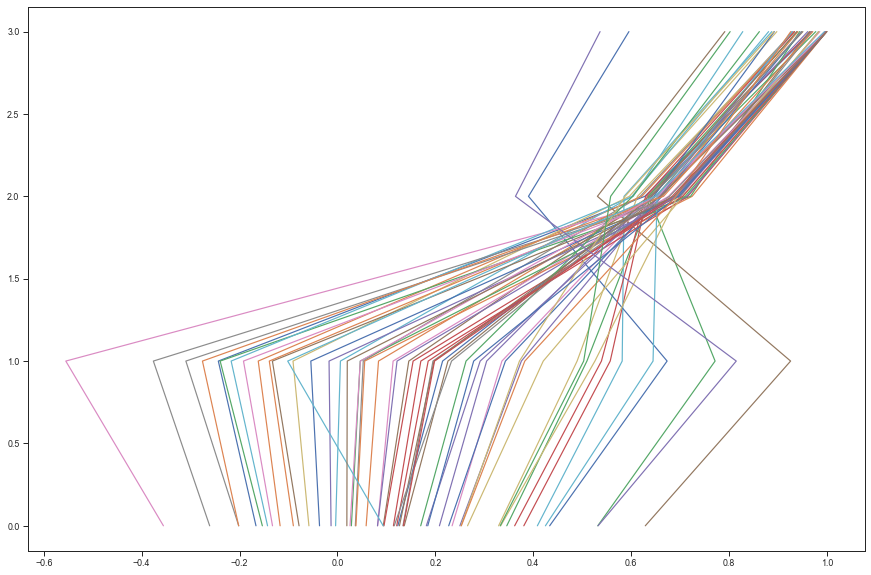

In [96]:
fig, ax = plt.subplots(figsize = (15,10))

Phi = np.array(mode_traces_mtc1[0].mode_shapes)

PhiT = koma.modal.align_modes(Phi.T)
Phi = PhiT.T

for phi in Phi:
    ax.plot( np.real(phi), np.arange(0, len(phi)))

In [49]:
n_missed_clustering = n_skipped_time_seg_clustering(freqs_out[25:], phis_out[25:], true_f[25:], true_phi[:,:,25:], lim = 0.3)
print(n_missed_clustering)
for trace in mode_traces_mtc1:
    print(trace.n_skipped_time_seg)

[72. 65. 24. 21.]
82
75
29
21


In [84]:
# y_all = np.array(mode_traces[3].mode_shapes[:10])

# y_all_temp, _ = koma.modal.normalize_phi(y_all.T)
# y_all = y_all_temp.T

# X = np.vstack([np.ones(len(mode_traces[3].time_seg[:10])), mode_traces[3].time_seg[:10]]).T

# print(y_all[:,1])
# print(X)

# phi_next = np.zeros_like(y_all[0,:])

# for i in range(phi_next.shape[0]):
#    yi = y_all[:,i]
#    bi = np.linalg.solve(X.T @ X, X.T @ yi)
#    phi_next[i] = bi[0] + bi[1] *(X[-1, -1] + 1)


# print(X@b0)
# print(phi_next)

# plt.figure(figsize=(15,10))
# plt.plot(X[:,1], np.real(y_all[:,0]))
# plt.plot(X[:,1], np.real(X@b0))

In [85]:
# print(mode_traces[3].frequencies[:10])
# print(mode_traces[3].time_seg[:10])
# print(np.ones(len(mode_traces[3].time_seg[:10])))

# y = mode_traces[3].frequencies[:10]
# X = np.vstack([np.ones(len(mode_traces[3].time_seg[:10])), mode_traces[3].time_seg[:10]]).T
# print(X)
# b = np.linalg.solve(X.T @ X, X.T @ y)

# print(b)

# print(X[-1, -1])

# f_next = b[0] + b[1] *(X[-1, -1] + 1)
# print(f_next)

# plt.figure(figsize=(15,10))
# plt.plot(X[:,1], y)
# plt.plot(X[:,1], X@b)

In [86]:
mode_traces = tk.perform_tracking(lambds_out, phis_out, n = 30, m = 8, d_track_threshold=0.1, method = 'average')

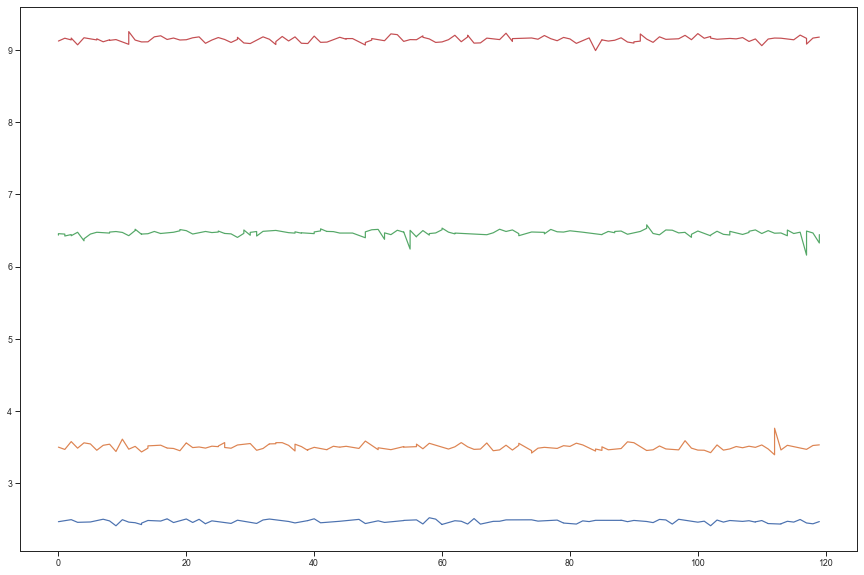

In [87]:
fig, axis = plt.subplots(figsize = (15,10))
for i in range(len(mode_traces)):
    plt.plot(mode_traces[i].time_seg, mode_traces[i].frequencies)

### Favarelli 2021

In [10]:
def gkern(theta, mu, std):
    """
    Gaussian kernel described in the relevant paper
    """
    return np.exp(-0.5*1/std**2*(theta-mu)**2)


def fsa_tilde(mu_pa, fsa1, sf):
    """
    Needed for trackingGaussian algorithm

    Arguments
    ---------
    mu_pa : 1d array
        all frequencies in the current time segment

    fsa1 : float
        fs from last time segment

    sf : float
        standard deviation of the gaussian kernel

    """
    kern = gkern(mu_pa, fsa1, sf)
    nom = np.sum(mu_pa*kern)
    denom = np.sum(kern)
    return nom/denom

In [21]:
def perform_tracking_favarelli(frequenciesHz, Nt = 200, N_lim = 250,  Bf = 0.4, epsilon = 0.7, sf = 0.01):
    """Tracking algorithm based on paper 'Machine Learning for Automatic Processing of Modal Analysis in Damage Detection
    of Bridges'

    Arguments
    ---------
    frequenciesHz : list with 1D arrays
        1st input: time segment
        2nd input: detected mode frequencies in Hz

        n detected modes
        frequenciesHz = [
            [f0_t0, f1_t0, ... , fn0_t0],
            [f0_t1, f1_t1, ... , fn1_t1],
            ...
            [f0_tend, f1_tend, ... , fnm_tend]
        ] 
    
    Nt : int
        Size of frequenciesHz to be used to estimate the initial frequencies

    N_lim : int
        Required amount of data points in a histogram column to be initialized as a starting frequency
    
    Bf : float
        Bandwith of bins in the histogram

    epsilon : float
        Controls the impact of the new observation. In the range of [0,1]

    sf : float
        Standard deviation of the Guassian kernel. Larger values of sf make the system more reactive to fast frequency changes during the tracking, but more sensitive to outliers due to the noisy measurements.

    plot_histogram : bool
        Specify as true if histogram is to be plotted

    Returns
    -------
    F_track : 2d array
        a sorted list of F containing the tracked frequencies over the time segments. The order is decided by the first time segment
    
    F_track = [
        [f0_t0], [f0_t1], ... , [f0_tend],
        [f1_t0], [f1_t1], ... , [f1_tend],
        ...
        [fn_t0], [fn_t1], ... , [fn_tend]
    ]
    
    """
    F_initial = frequenciesHz[:Nt]
    F_online = frequenciesHz[Nt:]

    #Initialize flattened lists of frequencies and shapes
    freqs_inital_flat = []

    #Add all the frequencies and shapes to the flattened lists
    for fk in F_initial:
        for fkj in fk:
            freqs_inital_flat.append(fkj)

    #Convert to numpy arrays (Easiest to append a 1D array to a python list and the convert to numpy)
    freqs_inital_flat = np.array(freqs_inital_flat)

    #Number of bins
    Nbins = int(np.ceil((freqs_inital_flat.max() - freqs_inital_flat.min())/Bf))
    
    #Make a histogram of the 
    hist, bin_edges = np.histogram(freqs_inital_flat, bins = Nbins, density = False)

    #Extract the initial frequencies
    id = np.array([i for i, v in enumerate(hist >= N_lim) if v]) #Find the highest peaks in the histogram

    #Find the bin edges for each of the detected initial frequency bins and reshape for easier for-loop
    found_bin_edges = np.array([])
    for i in id:
        found_bin_edges = np.append(found_bin_edges, np.array([bin_edges[i], bin_edges[i+1]]))
    found_bin_edges = found_bin_edges.reshape((int(found_bin_edges.shape[0]/2), 2))

    f0 = np.array([])

    for f_start, f_end in found_bin_edges:
        id_f = np.where(np.logical_and(freqs_inital_flat <= f_end, freqs_inital_flat >= f_start)) #Indices of frequencies in the bin
        f0 = np.append(f0, np.mean(freqs_inital_flat[id_f])) #Mean of the frequencies in the bin

    #Initialize F_track with as many rows as identified frequencies and as many columns as the remaining time segments
    F_track = np.zeros([f0.shape[0], len(F_online)])
    F_track[:,0] = f0 #Copy initial frequencies

    for a, mu_pa in enumerate(F_online):
        if a == 0:
            continue
        else:
            for i in range(f0.shape[0]):
                fsa_tilde_i = fsa_tilde(mu_pa, F_track[i,a-1], sf)
                F_track[i,a] = (1-epsilon)*F_track[i,a-1] + epsilon*fsa_tilde_i
    return F_track


In [22]:
data_true = np.load('../../Numerical test case/test_3/test_results/test_3_true.npz',allow_pickle=True)
true_f = data_true['arr_0']
true_phi = data_true['arr_1']

data = np.load('../../Numerical test case/test_3/test_results/test_3_run_'+str(0)+'.npz',allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

Text(25, 0.05, '$N_{t}$ = 25')

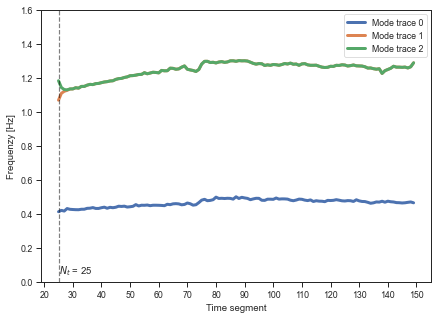

In [23]:
freqs_tracked = perform_tracking_favarelli(freqs_out, Nt = 25, N_lim = 10,  Bf = 0.1, epsilon = 0.7, sf = 0.01)

fig, ax = plt.subplots(figsize = (7,5))

t = np.arange(25,150)

for i, freqs in enumerate(freqs_tracked):
    ax.plot(t, freqs, label = 'Mode trace {}'.format(i), linewidth = 3)

ax.legend()
ax.set_xlabel('Time segment')
ax.set_ylabel('Frequenzy [Hz]')
ax.set_xticks(np.arange(0, 151, 10))
ax.plot([25, 25], [0, 1.6], linestyle = 'dashed', color = 'black', alpha = 0.5)
ax.set_ylim((0, 1.6))
ax.annotate('$N_{t}$ = 25', xy = (25, 0.05))


In [17]:
Nt = 25
Bf = 0.1
N_lim = 10
epsilon = 0.7
sf = 0.01

F_initial = freqs_out[:Nt]
F_online = freqs_out[Nt:]

#Initialize flattened lists of frequencies and shapes
freqs_inital_flat = []

#Add all the frequencies and shapes to the flattened lists
for k, fk in enumerate(F_initial):
    for j, fkj in enumerate(fk):
        freqs_inital_flat.append(fkj)

#Convert to numpy arrays (Easiest to append a 1D array to a python list and the convert to numpy)
freqs_inital_flat = np.array(freqs_inital_flat)

#Number of bins
Nbins = int(np.ceil((freqs_inital_flat.max() - freqs_inital_flat.min())/Bf))

#Make a histogram of the 
hist, bin_edges = np.histogram(freqs_inital_flat, bins = Nbins, density = False)

#Extract the initial frequencies
id = np.array([i for i, v in enumerate(hist >= N_lim) if v]) #Find the highest peaks in the histogram

#Find the bin edges for each of the detected initial frequency bins and reshape for easier for-loop
found_bin_edges = np.array([])
for i in id:
    found_bin_edges = np.append(found_bin_edges, np.array([bin_edges[i], bin_edges[i+1]]))
found_bin_edges = found_bin_edges.reshape((int(found_bin_edges.shape[0]/2), 2))


f0 = np.array([])

for f_start, f_end in found_bin_edges:
    id_f = np.where(np.logical_and(freqs_inital_flat <= f_end, freqs_inital_flat >= f_start)) #Indices of frequencies in the bin
    f0 = np.append(f0, np.mean(freqs_inital_flat[id_f])) #Mean of the frequencies in the bin

#Initialize F_track with as many rows as identified frequencies and as many columns as the remaining time segments
F_track = np.zeros([f0.shape[0], len(F_online)])
F_track[:,0] = f0 #Copy initial frequencies

for a, mu_pa in enumerate(F_online):
    if a == 0:
        continue
    else:
        for i in range(f0.shape[0]):
            fsa_tilde_i = fsa_tilde(mu_pa, F_track[i,a-1], sf)
            F_track[i,a] = (1-epsilon)*F_track[i,a-1] + epsilon*fsa_tilde_i

Text(25, 0.05, '$N_{t}$ = 25')

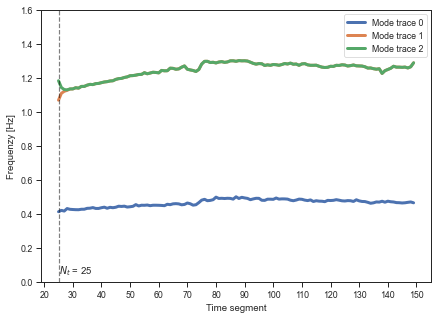

In [16]:
fig, ax = plt.subplots(figsize = (7,5))

t = np.arange(25,150)

for i, freqs in enumerate(F_track):
    ax.plot(t, freqs, label = 'Mode trace {}'.format(i), linewidth = 3)

ax.legend()
ax.set_xlabel('Time segment')
ax.set_ylabel('Frequenzy [Hz]')
ax.set_xticks(np.arange(0, 151, 10))
ax.plot([25, 25], [0, 1.6], linestyle = 'dashed', color = 'black', alpha = 0.5)
ax.set_ylim((0, 1.6))
ax.annotate('$N_{t}$ = 25', xy = (25, 0.05))

#fig.savefig('./figures/favarelli2021_tracking', dpi = 400, bbox_inches = 'tight')

### Distance matrix optimization

In [3]:
data = np.load('../../Numerical test case/test_3/test_results/test_3_run_'+str(0)+'.npz',allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

n = 5

freqs_inital = freqs_out[:n]
phis_initial = phis_out[:n]

#Initialize flattened lists of frequencies and shapes
freqs_inital_flat = []
phis_inital_flat = []

#Add all the frequencies and shapes to the flattened lists
for k, fk in enumerate(freqs_inital):
    phik = phis_initial[k]
    for j, fkj in enumerate(fk):
        phikj = phik[j,:]
        freqs_inital_flat.append(fkj)
        phis_inital_flat.append(phikj)

#Convert to numpy arrays (Easiest to append a 1D array to a python list and the convert to numpy)
freqs_inital_flat = np.array(freqs_inital_flat)
phis_inital_flat = np.array(phis_inital_flat)


In [4]:
#test = koma.clustering.crossdiff(phis_inital_flat)
dmacs = np.abs(1 - koma.modal.xmacmat(phis_inital_flat.T))
dfs = koma.clustering.crossdiff(freqs_inital_flat, relative=True, allow_negatives=False)

d_matrix_koma = dfs + dmacs

In [16]:
freq_lim = 0.8

id_div = np.where(freqs_inital_flat > freq_lim)[0]

print(id_div)


id_all = np.arange(freqs_inital_flat.shape[0])

print(id_all)

id_div_below = np.setdiff1d(id_all, id_div)

print(id_div_below)

[ 1  2  5  6  8  9 11 12 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  3  4  7 10 13 14]


In [15]:
print(d_matrix_koma[id_div][:,id_div].shape)

(10, 10)
